In [48]:
import time
import queue
import pandas as pd
import threading
from typing import Union, List
from tqdm import tqdm
from pathlib import Path 
import numpy as np
from datasets import Dataset
from transformers import PreTrainedTokenizerFast
from tokenizers.processors import TemplateProcessing
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from tokenizers.models import BPE
from statistics import mean, median
from tokenizers.pre_tokenizers import Digits, Whitespace, Sequence
import matplotlib.pyplot as plt
from Bio.Seq import translate
PathLike = Union[str, Path]
import re
import os
import torch

#from genslm.utils import read_fasta_only_seq, read_fasta, Sequence

# Assign a unique character to each codon so that we can use it as an
# input token to a BPE tokenizer. This implements a codon-pair encoding.
CODON_CHAR = {
    'TCG': "A", 'GCA': "B", 'CTT': "C", 'ATT': "D", 'TTA': "E", 'GGG': "F", 'CGT': "G", 
    'TAA': "H", 'AAA': "I", 'CTC': "J", 'AGT': "K", 'CCA': "L", 'TGT': "M", 'GCC': "N", 
    'GTT': "O", 'ATA': "P", 'TAC': "Q", 'TTT': "R", 'TGC': "S", 'CAC': "T", 'ACG': "U", 
    'CCC': "V", 'ATC': "W", 'CAT': "X", 'AGA': "Y", 'GAG': "Z", 'GTG': "a", 'GGT': "b", 
    'GCT': "c", 'TTC': "d", 'AAC': "e", 'TAT': "f", 'GTA': "g", 'CCG': "h", 'ACA': "i", 
    'CGA': "j", 'TAG': "k", 'CTG': "l", 'GGA': "m", 'ATG': "n", 'TCT': "o", 'CGG': "p", 
    'GAT': "q", 'ACC': "r", 'GAC': "s", 'GTC': "t", 'TGG': "u", 'CCT': "v", 'GAA': "w", 
    'TCA': "x", 'CAA': "y", 'AAT': "z", 'ACT': "0", 'GCG': "1", 'GGC': "2", 'CTA': "3", 
    'AAG': "4", 'AGG': "5", 'CAG': "6", 'AGC': "7", 'CGC': "8", 'TTG': "9", 'TCC': "!", 
    'TGA': "@"
}


def build_tokenizer(
    corpus_iterator,
    vocab_size,
    initial_alphabet: list[str],
    tokenizer_type: str,
    add_bos_eos: bool = True,
    max_length: int = 1024,
    save: bool = False,
    tokenzier_save_name: str = "cpe_tokenizer",
):
    special_tokens = {
        "unk_token": "[UNK]",
        "cls_token": "[CLS]",
        "sep_token": "[SEP]",
        "pad_token": "[PAD]",
        "mask_token": "[MASK]",
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
    }

    bos_index = 5
    eos_index = 6

    # Define tokenizer
    tokenizer = Tokenizer(BPE(unk_token = special_tokens["unk_token"]))
    
    if tokenizer_type == 'cpe_tokenizer':
        tokenizer.pre_tokenizer = Digits(individual_digits=False)
    
    else:
        tokenizer.pre_tokenizer = Whitespace()

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=list(special_tokens.values()),
        #initial_alphabet=initial_alphabet
    )

    print("Training tokenizer")

    tokenizer.train_from_iterator(corpus_iterator, trainer=trainer)
    # Add post-processor
    # trim_offsets=True will ignore spaces, false will leave them in
    tokenizer.post_processor = processors.ByteLevel(trim_offsets=True)
    if add_bos_eos:
        tokenizer.post_processor = TemplateProcessing(
            single="[BOS] $A [EOS]",
            special_tokens=[("[BOS]", bos_index), ("[EOS]", eos_index)],
        )

    # Add a decoder
    tokenizer.decoder = decoders.ByteLevel()

    # save the tokenizer
    wrapped_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer, **special_tokens
    )
    if save:
        wrapped_tokenizer.save_pretrained(tokenzier_save_name)
        
    print(f"Returning tokenizer with vocab_size = {tokenizer.get_vocab_size()}")

    return wrapped_tokenizer

In [49]:
def read_fasta_only_seq(fasta_file: PathLike) -> List[str]:
    """Reads fasta file sequences without description tag."""
    text = Path(fasta_file).read_text()
    pattern = re.compile("^>", re.MULTILINE)
    non_parsed_seqs = re.split(pattern, text)[1:]
    lines = [
        (line.replace("\n", "")).upper() for seq in non_parsed_seqs for line in seq.split("\n", 1)
    ]

    return lines[1::2]

def any_file_fasta_reader(fasta_file: PathLike) -> List[str]:
    if os.path.isdir(fasta_file):
        sequences_raw = []
        for p in Path(fasta_file).glob("*.fasta"):
            sequences_raw.extend(read_fasta_only_seq(p))
    elif os.path.isfile(fasta_file):
        sequences_raw = read_fasta_only_seq(fasta_file)
    else:
        raise ValueError(
            "Kindly enter a filepath to a directory containing many .fasta files "
            "or a filepath to a single .fasta file"
        )
    
    return sequences_raw
        

def group_and_contextualize_split_every_n(seq: str, n):
    seq.replace(" ", "")
    remainder = len(seq) % n
    if remainder != 0:
        seq = seq[:-remainder]  # Remove the last remainder characters
    substrings = [seq[i:i + n] for i in range(0, len(seq), n)]
    return ' '.join(substrings)

def group_and_contextualize_cpe(seq: str, k: int = 3): 
    return "".join(CODON_CHAR.get(seq[i : i + k], "") for i in range(0, len(seq), k))

def make_str_div(seq, n):
    remainder = len(seq) % n
    #print(remainder)
    if remainder != 0:
        seq = seq[:-remainder]
    
    return seq

In [50]:
def plot_vocab_lens(sequence_fasta_file: str, max_vocab_len: int, increment: int, start: int, bpe_tokenizer_type: str):
    """_summary_

    Args:
        sequences [str]: _description_
        max_vocab_len (int): _description_
        increment (int): _description_
        bpe_tokenizer_type (str): choices: ["ape_tokenizer", "cpe_tokenizer", "npe_tokenizer"]
    """
    
    dna_sequences = any_file_fasta_reader(sequence_fasta_file)
    
    
     # data preprocessing dependent on tokenizer_type
    if bpe_tokenizer_type == "ape_tokenizer":
        sequences = [translate(seq.upper()) for seq in dna_sequences]
        initial_alphabet = ['R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'C', 'G', 'P', '_', 'X']
    
    elif bpe_tokenizer_type == "cpe_tokenizer":
        sequences = [group_and_contextualize_cpe(make_str_div(seq.upper(), 3)) for seq in dna_sequences]
        initial_alphabet = list(CODON_CHAR.values())
        
    elif bpe_tokenizer_type == "npe_tokenizer":
        sequences = [seq.upper() for seq in dna_sequences]
        initial_alphabet = ["A", "C", "T", "G"]

    else:
        raise ValueError("Please enter a valid bpe_tokenizer_type :)")


    num_tokens_in_vocab = {}
    per_vocab_in_vocab = {}
    
    for vocab_size in range(start, max_vocab_len, increment):
        # Build the tokenizer
        tokenizer = build_tokenizer(sequences, vocab_size, initial_alphabet, bpe_tokenizer_type)
        
        # List of the number of unique token ids for each tokenized sequence
        unique_lens = []
        
        print(f"Finding lens for {vocab_size}")
        for seq in tqdm(sequences[0:2000]):
            #print(tokenizer.vocab)
            
            tokenized_seq = tokenizer(seq, max_length=1024, padding="max_length", truncation=True, return_tensors="pt")
            # torch.unique finds all the individual tokens we USED to tokenize the sequence
            # len finds how many individual tokens we need to tokenize the sequence
            unique_lens.append(len(torch.unique(tokenized_seq['input_ids'])))
            
            # basic sanity check for right now
            if len(torch.flatten(tokenized_seq['input_ids'])) != 1024:
                raise ValueError("input_ids length mismatch")

        #print(unique_lens)
        
        #print(set(unique_lens))
        
        avg_num_unique_tokens = median(unique_lens)
        
        num_tokens_in_vocab[vocab_size] = avg_num_unique_tokens
        
        
        per_vocab_in_vocab[vocab_size] = avg_num_unique_tokens/len(tokenizer.vocab)
        print(per_vocab_in_vocab)
    
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    plt.scatter(num_tokens_in_vocab.keys(), num_tokens_in_vocab.values())
    plt.title(bpe_tokenizer_type + " absolute median num unique tokens")
    plt.xlabel("Vocab Size")
    plt.ylabel("Num Unique Tokens Used")
    for xy in zip(num_tokens_in_vocab.keys(), num_tokens_in_vocab.values()):
        plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
    plt.show()
    
    plt.scatter(per_vocab_in_vocab.keys(), per_vocab_in_vocab.values())
    plt.title(bpe_tokenizer_type + " relative median num unique tokens")
    plt.xlabel("Vocab Size")
    plt.ylabel("Percentage of Vocab Size Used")
    for xy in zip(per_vocab_in_vocab.keys(), per_vocab_in_vocab.values()):
        plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
    plt.show()
    



Training tokenizer



Returning tokenizer with vocab_size = 100
Finding lens for 100


100%|██████████| 2000/2000 [00:01<00:00, 1120.18it/s]


{100: 0.75}
Training tokenizer



Returning tokenizer with vocab_size = 150
Finding lens for 150


100%|██████████| 2000/2000 [00:01<00:00, 1042.22it/s]


{100: 0.75, 150: 0.6066666666666667}
Training tokenizer



Returning tokenizer with vocab_size = 200
Finding lens for 200


100%|██████████| 2000/2000 [00:01<00:00, 1024.00it/s]


{100: 0.75, 150: 0.6066666666666667, 200: 0.52}
Training tokenizer



Returning tokenizer with vocab_size = 250
Finding lens for 250


100%|██████████| 2000/2000 [00:01<00:00, 1002.31it/s]


{100: 0.75, 150: 0.6066666666666667, 200: 0.52, 250: 0.448}


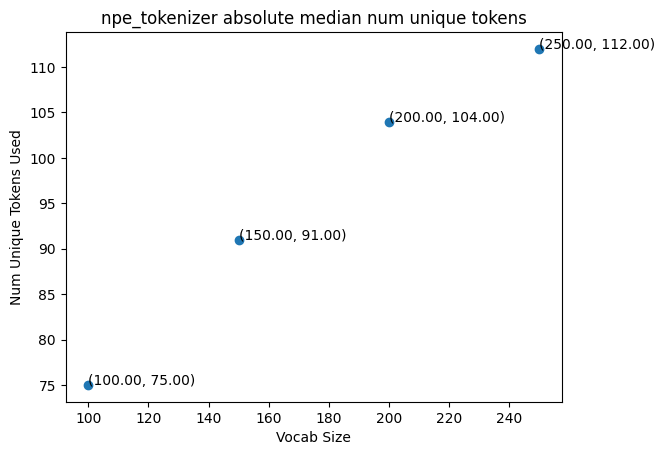

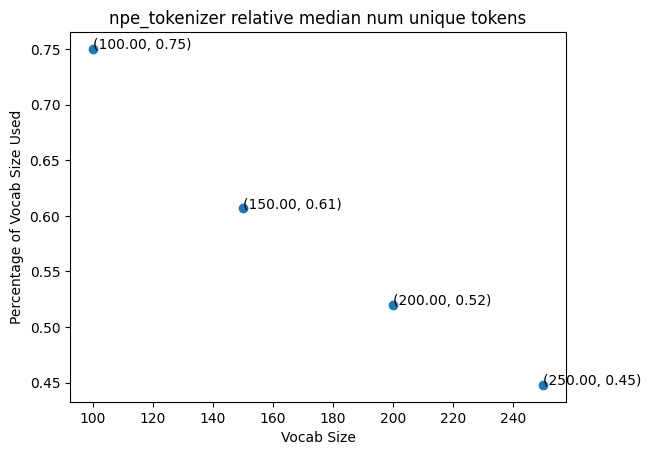

In [51]:
plot_vocab_lens(sequence_fasta_file='/home/couchbucks/Downloads/all_fasta_files/mdh_natural_sequences.ffn', max_vocab_len=300, increment=50, start = 100, bpe_tokenizer_type='npe_tokenizer')